## Summary
Part of a series that takes the formulas and MATLAB code found in Ernie Chan's book, Algorithmic Trading: Winning Strategies and Their Rationale (2013)

## Change Log
    Date Created: 2016-10-26
    
    Date of Change    Change Notes
    --------------    ----------------------------------------------------------------
    2016-10-26        Initial draft
    2016-10-27        Fixed formatting

## 1. General References  
  1.1 [Mathjax Basic Tutorial and Quick Reference](http://meta.math.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference)  
  1.2 [Github Markdown Cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#blockquotes)
  
## 2. Notebook References
 2.1 [CAGR](http://www.investopedia.com/terms/c/cagr.asp)  
 2.2 [Pandas Time Series Offset Aliases](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)

## 3. Backtesting and its relationship to Hypothesis Testing
---

The book suggests a general form of backtesting follows the hypothesis testing framework as follows:
  1. Compute the test statistic (average daily return for the active period)
  2. Assume the average daily return = 0, and call this the **null hypothesis**
  3. Assume Gaussian (Normal) Distribution of daily returns with 0 (zero) mean
  4. Using the null hypothesis assumed distribution of daily returns, compute the *p*-value. 
  5. Lookup *p*-value against critical values to determine significance
  
If *p*-value is less than 0.01 (less than 1% chance), we reject the null hypothesis, meaning the average daily returns from the backtest are statistically significant.

  
### 3.1 Sharpe Ratio Test Statistic (srt-stat)


The book cites a reference, (Bernston, 2002) with the citation stated as: 
    
> ... the standard test statistic for a Gaussian distribution is none other than the average divided by the standard deviation and multiplied by the square root of the number of data points ..."

which when written in equation form looks like:

$$\text{srt-stat} = \left(\frac{\mu}{\sigma}\right) \sqrt{n}$$

where:

\begin{align}
\mu  & = \text{the }\textbf{mean of the daily returns} \\ 
\sigma & = \text{the }\textbf{standard deviation of the daily returns} \\ 
n & = \text{the number of data points, also known as the }\textbf{number of samples}
\end{align}

The `srt_stat` is then then compared to a table of critical values to determine statistical significance, with the table again being cited from Bernston (2002) in Chan's book (code below):


| *p*-value | Critical values |
| --- | --- |
| 0.1 | 1.282 |
| 0.05 | 1.645 |
| 0.01 | 2.326 |
| 0.001 |3.091 |


*Note:*

* The smaller the *p*-value (or the larger the `srt_stat`), the better, with respect to being statistically significant.
* Because the Gaussian distriution is "described" by parameters (mu - $\mu$, and sigma - $\sigma$), the test is classified as a **parametric test**


## 4. Coding the Sharpe Ratio Test Statistic
---

First we setup the Jupyter Notebook to display charts nicely, followed up by sourcing 11 years of adjusted daily close price data from Yahoo! Finance, and then have a quick look at how to find a single days worth of data.

Adjusted closing prices are used as the data has been transformed to adapt for splits, reverse-splits, and dividends. This is important when holding stocks, as these will impact the returns of the strategy employed.

### 4.1 Setup

In [1]:
# Settings for plots
%matplotlib inline

import seaborn as sns  

sns.set_style('darkgrid')

In [2]:
# Get 11 years worth of daily adjusted prices from Yahoo Finance for Google stock price
# 
# Remote Data Access: Yahoo! Finance
#     https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-yahoo
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

start = datetime(2005, 1, 1)
end = datetime(2015, 12, 31)

# Only keep the adjusted closing prices
df = web.DataReader("GOOGL", 'yahoo', start=start, end=end)['Adj Close']
df.describe()

count    2769.000000
mean      324.799144
std       152.879584
min        87.582582
25%       222.667666
50%       281.346348
75%       405.560552
max       793.960022
Name: Adj Close, dtype: float64

In [3]:
# How to index into a particular date's adjusted closing price
df.ix['2010-01-07']

297.34735499999999

### 4.2 Compute Returns
We will now create a series of daily returns in percent, and view the top 5 records for the series.

In [4]:
# Create daily returns
# 
# Calculate Daily Returns with Pandas DataFrame
#     http://stackoverflow.com/a/33472722/893766
r = df.pct_change(1).dropna()
r.head(5)

Date
2005-01-04   -0.040501
2005-01-05   -0.005090
2005-01-06   -0.025632
2005-01-07    0.028109
2005-01-10    0.006242
Name: Adj Close, dtype: float64

### 4.3 Compute Test Statistic

Here we compute the test statistic and review the outcome. The test is performed by the following line in the code below:
    
    srt_stat = (mu / sigma) * np.sqrt(n)

In [5]:
# Compute srt-stat
# -> assumes a buy and hold strategy from the first date in the time series
# 
# Pandas DataFrame - Find row where values for column is maximal
#     http://stackoverflow.com/a/10213167/893766
import numpy as np

# ensure all numpy exceptions are raised
np.seterr(all='raise')

# critical values to test against for p-value
test_values = pd.DataFrame({
        'crits': [1.282, 1.645, 2.326, 3.091, ],
        'p_values': [0.1, 0.05, 0.01, 0.001, ]})

# test parameters
# r = percent daily returns
mu = r.mean()
sigma = r.std()
n = len(r)

# run the test
srt_stat = (mu / sigma) * np.sqrt(n)

# compare to crits
i = test_values['crits'] <= srt_stat
test_values = test_values[i]

# print if there is a significant result
if (len(test_values) > 0):
    result = test_values.ix[test_values['crits'].idxmax()]
    print("srt-stat\t{:.5}".format(srt_stat))
    print("crit\t\t{:.5}".format(result[0]))
    print("p-value\t\t{:.5}".format(result[1]))
    print()
    print("Significance:\tTest statistic is significant at the {}% level".format(int(result[1] * 100)))
    print("Outcome:\tReject the Null Hypothesis")
else:
    print("Significance:\tTest statistic did not pass any critical values")
    print("Outcome:\tFailed to reject the Null Hypothesis")

srt-stat	2.4804
crit		2.326
p-value		0.01

Significance:	Test statistic is significant at the 1% level
Outcome:	Reject the Null Hypothesis


## 5. Outcome
---

According to the test the Sharpe Ratio of the average daily returns is statistically significant.

Now what does that look like with $10,000 invested?


start_value:	10000
end_value:	35682.23146558856


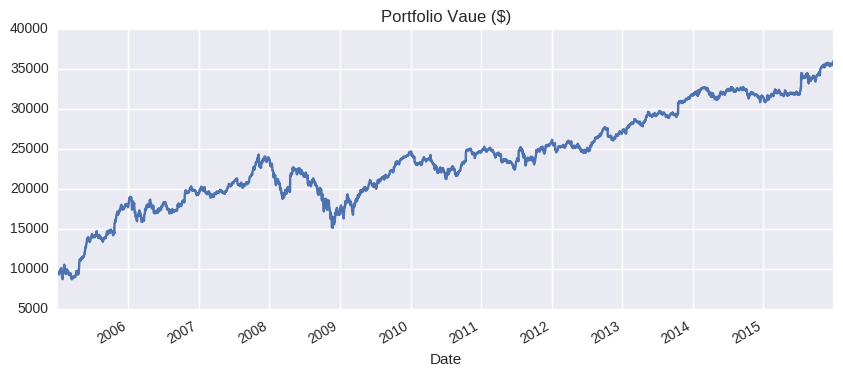

In [6]:
# Plot the returns of $10,000
# -> ignores transaction costs
start_value = 10000
actual_returns = (r.cumsum() + 1) * start_value
end_value = actual_returns[-1]

fig = actual_returns.plot(figsize=(10,4), title="Portfolio Vaue ($)")

print("start_value:\t{}\nend_value:\t{}".format(start_value, end_value))

## 6. CAGR

Investopedia provide the following for CAGR:

$$\text{CAGR} = \left(\frac{\text{End value}}{\text{Start value}}\right)^\left[\frac{1}{\text{n years}}\right]$$

Where typically the *n years* is adjusted for the total number of days in the investment period, like so:

$$\text{n years} = \frac{\text{Total number of days}}{365}$$

In our case this would give us:

\begin{align}
\text{n years} & = \frac{2769}{365} \\
& = 7.5863 \\
& \approx 7\frac{1}{2} years
\end{align}

However, in our example, because we're using daily data that doesn't trade all year round, we can't just take the number of days and divide ($\div$) by 365 to get an approximation for the number of years.

If we instead use the data to drive our decision we can count the number of days the stock traded each year, and make a decision to adjust the *n years* formula using this information like so:

$$\text{n years} = \frac{\text{Total number of days}}{\text{Average trading days per annum}}$$

### 6.1 Finding the average number of trading days per annum
The code below shows how to find the number of trading days, for each year (assumes every day that we have an adjusted close price, the market was open and the stock was able to be traded):

In [7]:
# Count number of rows in each year. Implicitly we are counting number of days,
# as one row exists for each day.
years = df.groupby(pd.TimeGrouper(freq="AS")).count()
years

Date
2005-01-01    252
2006-01-01    251
2007-01-01    251
2008-01-01    253
2009-01-01    252
2010-01-01    252
2011-01-01    252
2012-01-01    250
2013-01-01    252
2014-01-01    252
2015-01-01    252
Freq: AS-JAN, Name: Adj Close, dtype: int64

As we can see from above, the number of days ranged from 250-253, however if we just take the median of these stats we can use this for our calculation.

### 6.2 Average days traded per year
The code for the median is very simple:

In [8]:
avg_annual_days_traded = years.median()
avg_annual_days_traded

252.0

We can use this to adjust the formula used previously to:

\begin{align}
\text{n years} & = \frac{2769}{252} \\
& = 10.98809 \\
& \approx 11 \text{years}
\end{align}

As can now be seen, there is a vast difference between 7$\frac{1}{2}$ years and 11 years. This increases the amount of time we held our stocks by $\approx$ 46%!

### 6.3 CAGR with correct `avg_annual_days_traded`
We now have enough information to complete the formula, the code:

In [9]:
days_traded = len(r)
n_years = days_traded / avg_annual_days_traded

cagr = (end_value / start_value) ** (1 / n_years)
print("Compound annual growth rate (CAGR) = {:5.4}%".format((cagr - 1) * 100))

Compound annual growth rate (CAGR) = 12.28%


### 6.4 Incorrect `avg_annual_days_traded` and inflated CAGR
And the CAGR with the incorrect `n_years` of $\approx$ 7.5 (instead of the correct $\approx$ 11):

In [10]:
# Note: the n_years calculation is different
days_traded = len(r)
n_years = days_traded / 365

cagr = (end_value / start_value) ** (1 / n_years)
print("Compound annual growth rate (CAGR) = {:5.4}%".format((cagr - 1) * 100))

Compound annual growth rate (CAGR) = 18.26%


The incorrect CAGR of 18.26% is quite impressive for long-term buy-and-hold, unfortunately it is incorrect.

This stresses the importance of correctly measuring the performance of any backtests, which is reliant on understanding the data you're working with.